![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.


In [2]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

### DATA PREPROCESSING


In [5]:
#getting the images into appropriate format
X_train = np.transpose(train['X'], (3,0,1,2))
y_train_old = train['y']

X_test = np.transpose(test['X'], (3,0,1,2))
y_test_old = test['y']

In [6]:
y_train_old = y_train_old.reshape(len(y_train_old),)
y_test_old = y_test_old.reshape(len(y_test_old),)

In [7]:
y_train = y_train_old - 1
y_test = y_test_old - 1

1	9	2	3	2	5	9	3	3	1	

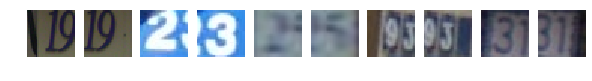

In [8]:
fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    print(y_train[i]+1,end ="\t")

1	9	2	3	2	5	9	3	3	1	

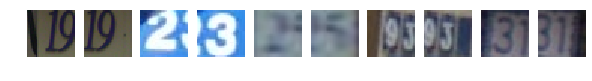

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i], cmap='gray')
    print(y_train[i]+1, end ="\t")

In [10]:
#sum across a dimension
X_train = np.sum(X_train, axis=3)[..., np.newaxis]/(255*3)
X_test = np.sum(X_test, axis=3)[..., np.newaxis]/(255*3)

## MLP neural network classifier


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint as MC
from tensorflow.keras.callbacks import EarlyStopping as ES

In [12]:
mlp_model = Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax'),
])

In [13]:
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [14]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpoint_path_mlp = 'model_checkpoints_best/checkpoint'

checkpoint_best_mlp = MC(
    filepath = checkpoint_path_mlp,
    frequency = 'epoch',
    save_best_only = True,
    monitor='val_accuracy',
    save_weights_only=False,
    verbose=1)

earlystop = ES(
    monitor='val_accuracy',
    patience=5,
    verbose=0,
    mode='max')

In [16]:
callbacks = [checkpoint_best_mlp, earlystop]

In [19]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=27, batch_size = 64, validation_data = (X_test,y_test), callbacks = callbacks)

Train on 73257 samples, validate on 26032 samples
Epoch 1/27
73152/73257 [============================>.] - ETA: 0s - loss: 1.9791 - accuracy: 0.3025
Epoch 00001: val_accuracy improved from -inf to 0.47922, saving model to model_checkpoints_best/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_checkpoints_best/checkpoint/assets
73257/73257 [==============================] - 30s 404us/sample - loss: 1.9784 - accuracy: 0.3029 - val_loss: 1.5651 - val_accuracy: 0.4792
Epoch 2/27
73024/73257 [============================>.] - ETA: 0s - loss: 1.3918 - accuracy: 0.5435
Epoch 00002: val_accuracy improved from 0.47922 to 0.55117, saving model to model_checkpoints_best/checkpoint
INFO:tensorflow:Assets written to: model_checkpoints_best/checkpoint/assets
73257/73257 [==============================] - 27s 375us/sample - loss: 1.3912 - accuracy: 0.5436 - val_loss: 1.3783 - val_accuracy: 0.5512
Epoch 3/27
73216/732

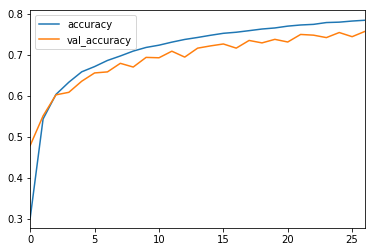

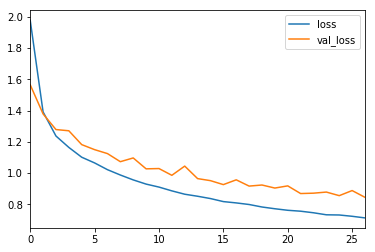

In [24]:
mlp_df = pd.DataFrame(mlp_history.history)
mlp_df.plot(y=['accuracy', 'val_accuracy'])
mlp_df.plot(y=['loss', 'val_loss'])

In [28]:
v_loss, v_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
print("Validation Loss: %f and Validation Accuracy: %f" %(v_loss, v_acc*100))

Validation Loss: 0.844021 and Validation Accuracy: 75.676090


## CNN neural network classifier

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [19]:
X_train.shape

(73257, 32, 32, 1)

In [20]:
cnn_model = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape =(32, 32, 1)),
    MaxPool2D((3,3)),
    Conv2D(8, (3,3), activation='relu'),
    Flatten(),
    Dense(216),
    Dense(10, activation ='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [21]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 216)               110808    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2170      
Total params: 114,298
Trainable params: 114,298
Non-trainable params: 0
________________________________________________

In [22]:
checkpoint_path_cnn = 'model_checkpoints_best_cnn/checkpoint'

checkpoint_best_cnn = MC(
    filepath = checkpoint_path_cnn,
    frequency = 'epoch',
    save_best_only = True,
    monitor='val_accuracy',
    save_weights_only=False,
    verbose=1)

earlystop = ES(
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='min')

In [23]:
callbacks_cnn = [checkpoint_best_cnn, earlystop]

In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=27, batch_size = 128, validation_data = (X_test,y_test), callbacks = callbacks_cnn)

Train on 73257 samples, validate on 26032 samples
Epoch 1/27
73216/73257 [============================>.] - ETA: 0s - loss: 1.6888 - accuracy: 0.4356
Epoch 00001: val_accuracy improved from -inf to 0.65635, saving model to model_checkpoints_best_cnn/checkpoint
INFO:tensorflow:Assets written to: model_checkpoints_best_cnn/checkpoint/assets
73257/73257 [==============================] - 137s 2ms/sample - loss: 1.6884 - accuracy: 0.4357 - val_loss: 1.1164 - val_accuracy: 0.6563
Epoch 2/27
73216/73257 [============================>.] - ETA: 0s - loss: 0.9070 - accuracy: 0.7334
Epoch 00002: val_accuracy improved from 0.65635 to 0.76498, saving model to model_checkpoints_best_cnn/checkpoint
INFO:tensorflow:Assets written to: model_checkpoints_best_cnn/checkpoint/assets
73257/73257 [==============================] - 135s 2ms/sample - loss: 0.9070 - accuracy: 0.7335 - val_loss: 0.8404 - val_accuracy: 0.7650
Epoch 3/27
73216/73257 [============================>.] - ETA: 0s - loss: 0.7279 - accu

In [ ]:
mlp_df = pd.DataFrame(mlp_history.history)
mlp_df.plot(y=['accuracy', 'val_accuracy'])
mlp_df.plot(y=['loss', 'val_loss'])

In [ ]:
v_loss, v_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
print("Validation Loss: %f and Validation Accuracy: %f" %(v_loss, v_acc*100))

## model predictions

In [24]:
reload_model_mlp = tf.keras.models.load_model(checkpoint_path_mlp)

# Check its architecture
reload_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


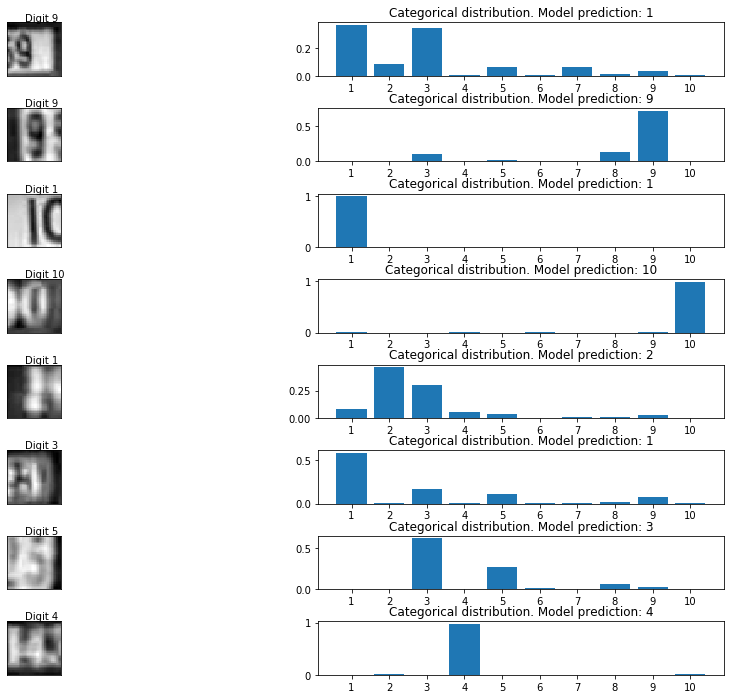

In [25]:
num_test_images = X_test.shape[0]

rand_idx = np.random.choice(num_test_images, 8)

rand_test_img = X_test[rand_idx, ...]
rand_test_label = y_test_old[rand_idx, ...]

preds = reload_model_mlp.predict(rand_test_img)

fig, axes = plt.subplots(8,2, figsize=(16,12))
fig.subplots_adjust(hspace=0.6, wspace  = 0.2)

for i, (prediction, image, label) in enumerate(zip(preds, rand_test_img, rand_test_label)):
    axes[i,0].imshow(np.squeeze(image),cmap='gray')
    axes[i,0].get_xaxis().set_visible(False)
    axes[i,0].get_yaxis().set_visible(False)
    axes[i,0].text(10., -1.5, f'Digit {label}')
    axes[i,1].bar(np.arange(1,len(prediction)+1), prediction)
    axes[i,1].set_xticks(np.arange(1, len(prediction)+1))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)+1}")
                   
plt.show()     

In [26]:
reload_model_cnn = tf.keras.models.load_model(checkpoint_path_cnn)

# Check its architecture
reload_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 216)               110808    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2170      
Total params: 114,298
Trainable params: 114,298
Non-trainable params: 0
________________________________________________

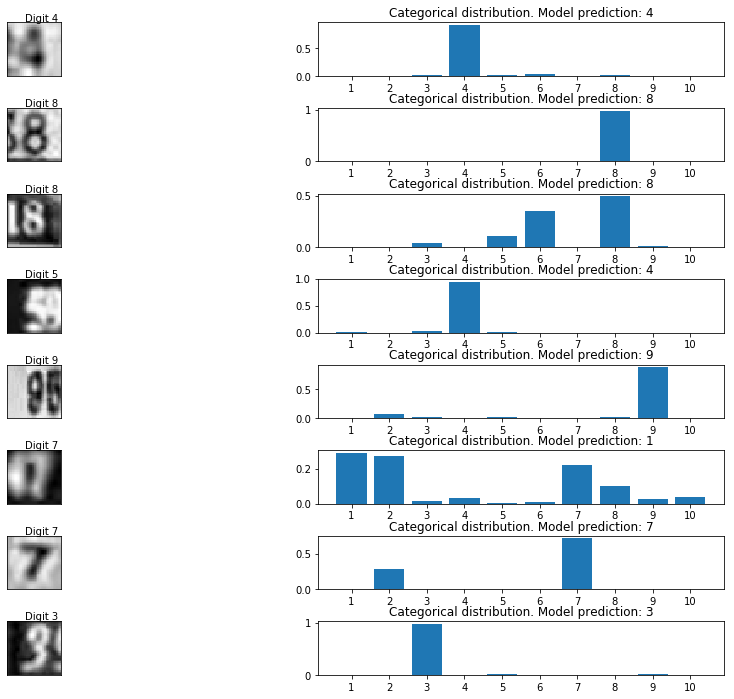

In [27]:
num_test_images = X_test.shape[0]

rand_idx = np.random.choice(num_test_images, 8)

rand_test_img = X_test[rand_idx, ...]
rand_test_label = y_test_old[rand_idx, ...]

preds = reload_model_cnn.predict(rand_test_img)

fig, axes = plt.subplots(8,2, figsize=(16,12))
fig.subplots_adjust(hspace=0.6, wspace  = 0.2)

for i, (prediction, image, label) in enumerate(zip(preds, rand_test_img, rand_test_label)):
    axes[i,0].imshow(np.squeeze(image),cmap='gray')
    axes[i,0].get_xaxis().set_visible(False)
    axes[i,0].get_yaxis().set_visible(False)
    axes[i,0].text(10., -1.5, f'Digit {label}')
    axes[i,1].bar(np.arange(1,len(prediction)+1), prediction)
    axes[i,1].set_xticks(np.arange(1, len(prediction)+1))
    axes[i,1].set_title(f"Categorical distribution. Model prediction: {((np.argmax(prediction))+1)%10}")
                   
plt.show()                 